## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from random import sample

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
110928,00030254_001.png,No Finding,1,30254,48,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030254_001.png
83104,00020410_005.png,Consolidation,5,20410,82,F,AP,3056,2544,0.139000,0.139000,NaN,/data/images_009/images/00020410_005.png
96143,00025294_000.png,Infiltration,0,25294,12,M,PA,2418,2641,0.143000,0.143000,NaN,/data/images_011/images/00025294_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
43667,00011243_001.png,Pleural_Thickening,1,11243,45,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13399,00003489_003.png,,3,3489,51,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22244,00005895_024.png,,24,5895,54,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: 'Pneumonia' if x == 1 else 'No Pneumonia')

## Create your training and testing data:

In [5]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    train_data, val_data = train_test_split(all_xray_df, test_size=0.2, random_state=42)

    # balance the training set
    train_data = train_data.groupby('pneumonia_class').apply(lambda x: x.sample(train_data['pneumonia_class'].value_counts().min()).reset_index(drop=True))
    train_data = train_data.reset_index(drop=True)

    # Sample proportionally for validation set
    p_inds = val_data[val_data['pneumonia_class'] == 'Pneumonia'].index.tolist()
    np_inds = val_data[val_data['pneumonia_class'] == 'No Pneumonia'].index.tolist()

    # The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
    np_sample = sample(np_inds,4*len(p_inds))
    val_data = val_data.loc[p_inds + np_sample]
        
    return train_data, val_data
    


In [6]:
train_data, val_data = create_splits(all_xray_df)

In [7]:
train_data['pneumonia_class'].value_counts()

No Pneumonia    1137
Pneumonia       1137
Name: pneumonia_class, dtype: int64

In [8]:
val_data['pneumonia_class'].value_counts()

No Pneumonia    1176
Pneumonia        294
Name: pneumonia_class, dtype: int64

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [9]:
def my_image_augmentation_train():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    train_idg = ImageDataGenerator(rescale=1. / 255,
                                horizontal_flip = True,
                                vertical_flip = False,
                                rotation_range=20,
                                zoom_range=0.2,
                                shear_range=0.2,
                                fill_mode='nearest',
                                width_shift_range=0.2,
                                height_shift_range=0.2)
    
    
    return train_idg


def my_image_augmentation_val():
    
    
    
    val_idg = ImageDataGenerator(rescale=1. / 255,
                                samplewise_center=True,
                                samplewise_std_normalization=True)
    
    return val_idg


def make_train_gen(idg, train_df):
    
    train_gen = idg.flow_from_dataframe(dataframe = train_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = (224, 224), 
                                             batch_size = 32)   

    return train_gen


def make_val_gen(idg, val_df):
    
    val_gen = idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = (224, 224), 
                                             batch_size = 1024)
    
    return val_gen

In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(my_image_augmentation_val(), val_data)
valX, valY = val_gen.next()

Found 1470 validated image filenames belonging to 2 classes.


Found 2274 validated image filenames belonging to 2 classes.


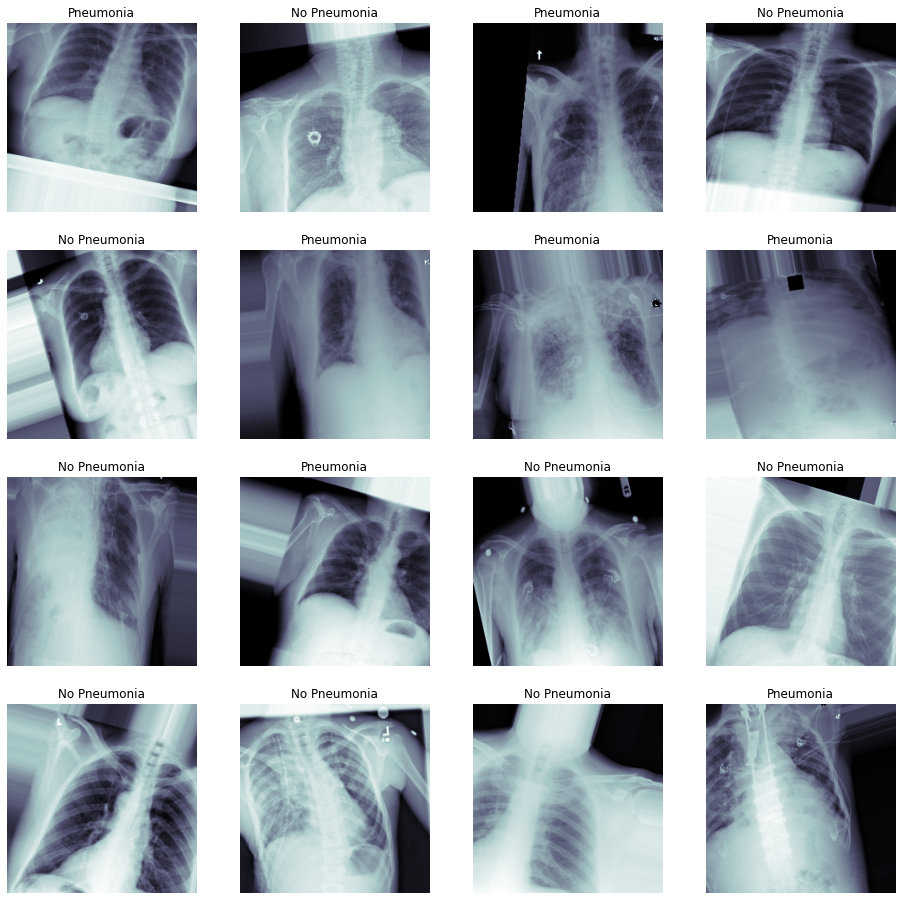

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
train_gen = make_train_gen(my_image_augmentation_train(), train_data)

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet', input_shape=(224, 224, 3))
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    vgg_model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = vgg_model.get_layer('block5_pool')
    vgg_model = Model(inputs = vgg_model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[:-4]:  # Freeze all layers except the last 4
        layer.trainable = False
    
        
    return vgg_model


In [13]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    my_model = Sequential()
    my_model.add(load_pretrained_model())
    my_model.add(Flatten())
    my_model.add(Dense(256, activation='relu'))
    my_model.add(BatchNormalization())
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation='sigmoid'))

    for layer in vgg_model.layers:  # Freeze pre-trained layers
        layer.trainable = False

    my_model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [14]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min',
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [15]:
## train your model

vgg_model = load_pretrained_model()
my_model = build_my_model()


history = my_model.fit_generator(train_gen,
                                validation_data = (valX, valY),
                                epochs = 15,
                                callbacks = callbacks_list)



553467904/553467096 [==============================] - 3s 0us/step
Epoch 1/15
72/72 [==============================] - 71s 986ms/step - loss: 0.8779 - accuracy: 0.5374 - val_loss: 0.5398 - val_accuracy: 0.7715

Epoch 00001: val_loss improved from inf to 0.53982, saving model to xray_class_my_model.best.hdf5
Epoch 2/15
72/72 [==============================] - 58s 805ms/step - loss: 0.8083 - accuracy: 0.5585 - val_loss: 0.6044 - val_accuracy: 0.6729

Epoch 00002: val_loss did not improve from 0.53982
Epoch 3/15
72/72 [==============================] - 59s 814ms/step - loss: 0.7993 - accuracy: 0.5638 - val_loss: 0.5964 - val_accuracy: 0.6768

Epoch 00003: val_loss did not improve from 0.53982
Epoch 4/15
72/72 [==============================] - 60s 830ms/step - loss: 0.7537 - accuracy: 0.5770 - val_loss: 0.6392 - val_accuracy: 0.6602

Epoch 00004: val_loss did not improve from 0.53982
Epoch 5/15
72/72 [==============================] - 59s 813ms/step - loss: 0.7727 - accuracy: 0.5712 - val

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [16]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, verbose = True)

1024/1024 [==============================] - 5s 5ms/step


In [17]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    
    return fpr, tpr, thresholds
    

## what other performance statistics do you want to include here besides AUC? 

    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    return

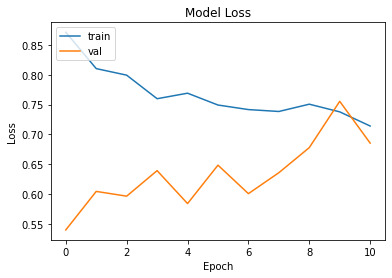

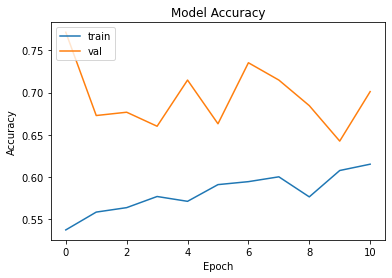

F1 Score: 0.16428571428571428


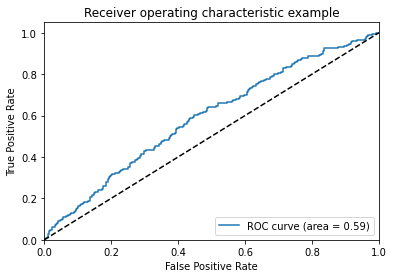

In [18]:
## plot figures

plot_history(history)
fpr, tpr, thresholds = plot_auc(valY, pred_Y)
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

# Threshold probabilities to get binary predictions
pred_labels = (pred_Y >= 0.5).astype(int)

# Calculate F1 score
f1 = f1_score(valY, pred_labels)
print(f"F1 Score: {f1}")

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [19]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

def find_best_threshold(t_y, p_y):
    
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    f1 = 2*(precision*recall)/(precision+recall)
    best_threshold = thresholds[np.argmax(f1)]
    
    return best_threshold

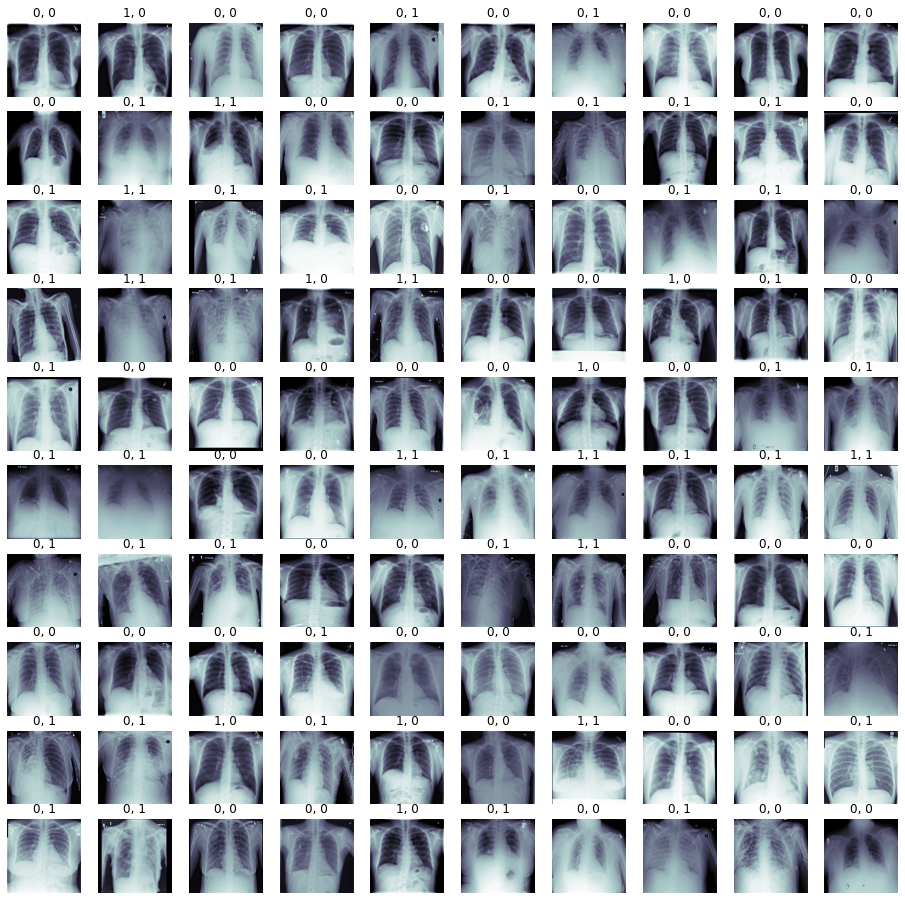

In [20]:
## Let's look at some examples of true vs. predicted with our best model: 


YOUR_THRESHOLD = find_best_threshold(valY, pred_Y)


fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [21]:
print(YOUR_THRESHOLD)

0.3194286


In [22]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)